# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

> NOTE: If you're running this locally - please skip this step.

In [1]:
#!pip install -qU langchain langchain_openai langchain-community langgraph arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.4/412.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.1 MB/s eta 0:00:00


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [4]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE6 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [61]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper

# Initialize the Wikipedia API wrapper
wikipedia_api_wrapper = WikipediaAPIWrapper()

# Initialize the tools
tavily_tool = TavilySearchResults(max_results=5)
arxiv_tool = ArxivQueryRun()
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)

# Assemble the tool belt
tool_belt = [
    tavily_tool
    , arxiv_tool
    , wikipedia_tool
]


In [62]:
wikipedia_tool.invoke({'query': 'History of the Internet'})

'Page: History of the Internet\nSummary: The history of the Internet originated in the efforts of scientists and engineers to build and interconnect computer networks. The Internet Protocol Suite, the set of rules used to communicate between networks and devices on the Internet, arose from research and development in the United States and involved international collaboration, particularly with researchers in the United Kingdom and France.\nComputer science was an emerging discipline in the late 1950s that began to consider time-sharing between computer users, and later, the possibility of achieving this over wide area networks. J. C. R. Licklider developed the idea of a universal network at the Information Processing Techniques Office (IPTO) of the United States Department of Defense (DoD) Advanced Research Projects Agency (ARPA). Independently, Paul Baran at the RAND Corporation proposed a distributed network based on data in message blocks in the early 1960s, and Donald Davies concei

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [63]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [64]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?
The model in this case is provided with a list of tools that it can use. The LLM decides which tool to call based on the user's input and the description of the tool. The model scores each tool based on the user's intent and then selects the one which scores the highest. Also as the model has context awareness, it puts that knowledge to use as well. In conclusion, it is learned behavior from fine-tuning on many examples of when to use which tool based on intent and tool signature.

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [142]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  steps_taken: int  # New field to track cycles
  history: list[str]  # ✅ NEW: track steps taken


## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [143]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  steps = state.get("steps_taken", 0)
  history = state.get("history", [])

  response = model.invoke(messages)

  return {
    "messages" : [response],
    "steps_taken": steps + 1, 
    "history": history + [f"Step {steps + 1}: Agent called model."]
  }

tool_node = ToolNode(tool_belt)

def call_tool(state: AgentState) -> AgentState:
    new_state = tool_node.invoke(state)
    history = state.get("history", [])
    steps = state.get("steps_taken", 0)

    new_state["history"] = history + [f"Step {steps}: Tool executed."]
    return new_state

In [144]:
tool_belt

[TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000)),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/Users/viveknatan/Documents/AIMCourse/agent/05_Our_First_Agent_with_LangGraph/.venv/lib/python3.13/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))]

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [145]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", call_tool)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [146]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [147]:
def should_continue(state: AgentState) -> str:
    steps = state.get("steps_taken", 0)
    if steps >= 5:
        state["history"].append(f"Step {steps}: Reached max step limit. Ending.")
        return END

    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "action"

    state["history"].append(f"Step {steps}: No tool call. Ending.")
    return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [148]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [149]:
compiled_graph = uncompiled_graph.compile()

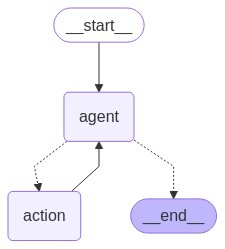

In [150]:
compiled_graph

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [151]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the T20 Indian Cricket Team?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eMO3u4HIUeV6lP6D0PTfaT2A', 'function': {'arguments': '{"query":"current captain of T20 Indian Cricket Team 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 223, 'total_tokens': 252, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a6889ffe71', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b013f0fa-9fdb-4835-bd36-7b0f01926c0a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current captain of T20 Indian Cricket Team 2023'}, 'id': 'call_eMO3u4HIUeV6lP6D0PTfaT2A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 22

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [153]:
# Restricted to a steps_taken of 2 or fewer.... The LLM doesnt complete the task and exits the loop mid way.
# inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, identify the authors and find if they have any Wikipedia pages, then search each of the authors to find out their latest Tweet using Tavily!")]}

# async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
#     for node, values in chunk.items():
#         print(f"Receiving update from node: '{node}'")
#         if node == "action":
#           print(f"Tool Used: {values['messages'][0].name}")
#         print(values["messages"])

#         print("\n\n")
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(
            content="Search Arxiv for the QLoRA paper, identify the authors and find if they have any Wikipedia pages, then search each of the authors to find out their latest Tweet using Tavily!"
        )
    ],
    "steps_taken": 0,
    "history": []
}

# 1. Stream the execution
async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")

        if node == "action":
            tool_call = values["messages"][0]
            print(f"Tool Used: {tool_call.name}")

        print(values["messages"])
        print("\n")

# 2. Run again to fetch full final state (includes `history`)
final_state = await compiled_graph.ainvoke(inputs)

# 3. Display history
print("\n=== History Trace ===\n")
for i, step in enumerate(final_state.get("history", []), 1):
    print(f"{i}. {step}")


Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VddaXPVk1kaqiRQGOxRupC3C', 'function': {'arguments': '{"query":"QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 248, 'total_tokens': 265, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a6889ffe71', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-da079734-62e1-42f5-b163-f8b0a7a0e58e-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'QLoRA'}, 'id': 'call_VddaXPVk1kaqiRQGOxRupC3C', 'type': 'tool_call'}], usage_metadata={'input_tokens': 248, 'output_tokens': 17, 'total_tokens': 265, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'a

In [126]:
# Restricted to a steps_taken of 5 or fewer.... The LLM completes the task and provides the final result.
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, identify the authors and find if they have any Wikipedia pages, then search each of the authors to find out their latest Tweet using Tavily!")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_R8gByxxHhW0e92vqktpkVVv6', 'function': {'arguments': '{"query":"QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 248, 'total_tokens': 265, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a6889ffe71', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5091bec2-1819-471c-8bb7-29594ece8cca-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'QLoRA'}, 'id': 'call_R8gByxxHhW0e92vqktpkVVv6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 248, 'output_tokens': 17, 'total_tokens': 265, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'a

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

1. Step 1: Agent called model.
2. Step 1: Tool executed. - Arxiv
3. Step 2: Agent called model.
4. Step 2: Tool executed. - Wikipedia
5. Step 3: Agent called model.
6. Step 3: Tool executed. - Tavily
7. Step 4: Agent called model.
8. Step 4: No tool call. Ending.


# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [82]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | compiled_graph | parse_output

In [85]:
agent_chain.invoke({"question" : "What is RAG in the context of AI?"})

/Users/viveknatan/Documents/AIMCourse/agent/05_Our_First_Agent_with_LangGraph/.venv/lib/python3.13/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/viveknatan/Documents/AIMCourse/agent/05_Our_First_Agent_with_LangGraph/.venv/lib/python3.13/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'In the context of AI, RAG stands for "Retrieval-Augmented Generation." It is a technique that enhances generative AI models by allowing them to retrieve and incorporate new information from external sources. This approach modifies interactions with a large language model (LLM) so that the model can respond to user queries by referencing a specified set of documents, supplementing the information from its pre-existing training data. This enables the use of domain-specific and updated information, improving the accuracy and relevance of the responses.\n\nRAG works by dynamically retrieving relevant text from databases, uploaded documents, or web sources before generating responses. This method helps reduce AI hallucinations and allows LLMs to provide more accurate responses without frequent retraining. Additionally, RAG can include source references in responses, enabling users to verify information by reviewing cited documents or original sources, thus providing greater transparency. T

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [93]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]}
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [94]:
from langsmith import Client
client = Client()

# dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

# dataset = client.create_dataset(
#     dataset_name=dataset_name,
#     description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
# )

# client.create_examples(
#     inputs=[{"question" : q} for q in questions],
#     outputs=answers,
#     dataset_id=dataset.id,
# )

# === Validate Data ===
if len(questions) != len(answers):
    raise ValueError(f"❌ Mismatch: {len(questions)} questions vs {len(answers)} answers.")

# === Dataset Creation ===
dataset_name = "qa_dataset"
try:
    dataset = client.read_dataset(dataset_name=dataset_name)
    print(f"ℹ️ Using existing dataset: {dataset.name}")
except Exception:
    dataset = client.create_dataset(
        dataset_name=dataset_name,
        description="Basic QA examples for LangChain eval tests"
    )
    print(f"✅ Created new dataset: {dataset.name}")

# === Create Examples ===
for idx, (question, expected) in enumerate(zip(questions, answers), 1):
    try:
        client.create_example(
            inputs={"question": question},
            outputs=expected,
            dataset_id=dataset.id
        )
        print(f"✅ [{idx}] Added: \"{question}\"")
    except Exception as e:
        print(f"❌ [{idx}] Failed: \"{question}\"\n   ↳ Error: {e}")

ℹ️ Using existing dataset: qa_dataset
✅ [1] Added: "What optimizer is used in QLoRA?"
✅ [2] Added: "What data type was created in the QLoRA paper?"
✅ [3] Added: "What is a Retrieval Augmented Generation system?"
✅ [4] Added: "Who authored the QLoRA paper?"
✅ [5] Added: "What is the most popular deep learning framework?"
✅ [6] Added: "What significant improvements does the LoRA system make?"


In [90]:
from langsmith import Client

client = Client()

dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

{'example_ids': ['f1833e2e-9e12-4455-b1c0-fba74f5d6f08',
  '18b0170c-b9cb-4eb3-acef-43a886f4a6c1',
  '49198dae-294a-4514-bf13-f03353360d52',
  'eac5a16d-4843-431f-af0d-8239eb8abc12',
  'add646cb-bb6d-4011-bb92-7871ec171bbc',
  '1d77238c-b65a-4f77-b31e-04ae27d96db6'],
 'count': 6}

#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not

A: The code implicitly assumes that the order of questions and answers matches 1-to-1. It also assumes that there will be the same number of questions and answers. I have included some changes to ensure tht the same number of questions and answers exist, ensure explicit pairing of questions and answers and exception handling and logging for failures

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [155]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

In [158]:
# Here is a slightly evolved version which corrects for case sensitivity and also credits partial scores for must contain.
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention_v2(run, example) -> EvaluationResult:
    prediction = (run.outputs.get("output") or "").lower()
    required = [r.lower() for r in example.outputs.get("must_mention", [])]

    matches = [phrase for phrase in required if phrase in prediction]
    score = len(matches) / len(required) if required else 1.0

    return EvaluationResult(
        key="must_mention",
        score=score,
        comment=f"Matched: {matches} | Missing: {[r for r in required if r not in matches]}"
    )


#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

The must_mention evaluator is deterministic, fast, easy to implement and usefulf for use cases with hard requirements. 
It does have some gaps, notably
1. It looks at the Exact string match
2. Doesnt account for case sensitivity
3. Does not take partial credit into account
4. It is not aware of the context and is just looking for the occurance of specific words

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [156]:
experiment_results = client.evaluate(
    agent_chain,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"RAG Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'RAG Pipeline - Evaluation - 55f8-343546e5' at:
https://smith.langchain.com/o/c9d5843a-35e9-4d41-83e6-32315ffaf39f/datasets/0d265a91-3a56-4dbe-a59c-fb829be3dc1b/compare?selectedSessions=4bb6a869-ba79-4c18-b012-e5fc8a35dc03




0it [00:00, ?it/s]

In [157]:
experiment_results

,inputs.question,outputs.output,error,reference.must_mention,feedback.must_mention,execution_time,example_id,id
0,What significant improvements does the LoRA sy...,"The LoRa system, which stands for ""Long Range,...",None,"[reduce, parameters]",False,9.587728,04eab0ad-5fc4-4057-90a7-8676c698d8b6,e8188ad9-7648-40cf-91cd-45030ecf987e
1,What is the most popular deep learning framework?,"In 2023, the most popular deep learning framew...",None,"[PyTorch, TensorFlow]",True,6.462374,3f900e87-3148-4956-bcc7-b1a8b4b1f62c,31b9983c-1bff-4d35-b534-6c8e00d74ac9
2,Who authored the QLoRA paper?,"The QLoRA paper titled ""Accurate LoRA-Finetuni...",None,"[Tim, Dettmers]",False,2.734182,f2b843fe-c0ae-4cfb-a332-61d728ea87b6,6f2efbe4-c6f0-4369-beb9-53dba57809d1
3,What is a Retrieval Augmented Generation system?,Retrieval-augmented generation (RAG) is a tech...,None,"[ground, context]",False,8.014176,9f9f6847-0f55-4e42-97a9-0c47f8ae923b,37cd6e57-714f-4b6a-b39b-1e5c3e246f2c
4,What data type was created in the QLoRA paper?,"In the QLoRA paper, a new data type called ""4-...",None,"[NF4, NormalFloat]",True,2.953289,7594421a-a611-4bb7-b4e5-4ee0e61e7832,6b4808ea-50c1-4a02-a319-b277598488f0
5,What optimizer is used in QLoRA?,"QLoRA uses ""paged optimizers"" to manage memory...",None,"[paged, optimizer]",True,2.453867,e8ae5a0b-504e-47cb-b62b-2ac3afea1a5d,9d1ef350-0a90-4880-a9a7-354606fd0a67
6,What significant improvements does the LoRA sy...,"The LoRa system, which stands for ""Long Range,...",None,"[reduce, parameters]",False,9.829428,7a608cab-d1c5-4cde-bbe7-fc9f9bd0d59b,3876092d-59a3-47c4-a2e1-24c5c66dce3b
7,What is the most popular deep learning framework?,"In 2023, the most popular deep learning framew...",None,"[PyTorch, TensorFlow]",True,3.781330,ae89f498-9b6f-4a10-87bc-97e4472cca99,44b6ca4d-45da-41e5-a0aa-ef02e59f5dcb
8,Who authored the QLoRA paper?,"The QLoRA paper titled ""Accurate LoRA-Finetuni...",None,"[Tim, Dettmers]",False,2.203096,45c765db-a98c-41e5-9136-cb4a854705da,c4311b54-7ce0-43ce-8f07-f238356734cd
9,What is a Retrieval Augmented Generation system?,Retrieval-augmented generation (RAG) is a tech...,None,"[ground, context]",False,6.599669,6f31743d-ef5f-4205-b7af-6d2a628c783c,de55f412-8631-4f85-a449-71c4ae8ba18e


In [161]:
experiment_results_v2 = client.evaluate(
    agent_chain,
    data=dataset_name,
    evaluators=[must_mention_v2],
    experiment_prefix=f"RAG Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'RAG Pipeline - Evaluation - 7267-7fca39f2' at:
https://smith.langchain.com/o/c9d5843a-35e9-4d41-83e6-32315ffaf39f/datasets/0d265a91-3a56-4dbe-a59c-fb829be3dc1b/compare?selectedSessions=1273f758-0865-48b6-af6f-77be990d7c7c




0it [00:00, ?it/s]

In [162]:
experiment_results_v2

,inputs.question,outputs.output,error,reference.must_mention,feedback.must_mention,execution_time,example_id,id
0,What significant improvements does the LoRA sy...,"The LoRa system, which stands for ""Long Range,...",None,"[reduce, parameters]",0.5,10.237442,04eab0ad-5fc4-4057-90a7-8676c698d8b6,095a703c-e1ef-43c6-b961-2fc0f92c029d
1,What is the most popular deep learning framework?,"In 2023, the most popular deep learning framew...",None,"[PyTorch, TensorFlow]",1.0,5.444331,3f900e87-3148-4956-bcc7-b1a8b4b1f62c,4fa5a265-097c-4afd-aeaf-fe83edf5c9a9
2,Who authored the QLoRA paper?,"The QLoRA paper titled ""Accurate LoRA-Finetuni...",None,"[Tim, Dettmers]",0.0,2.525303,f2b843fe-c0ae-4cfb-a332-61d728ea87b6,e710625a-810d-4b48-8fbd-041928796313
3,What is a Retrieval Augmented Generation system?,Retrieval-augmented generation (RAG) is a tech...,None,"[ground, context]",0.0,6.453169,9f9f6847-0f55-4e42-97a9-0c47f8ae923b,7e61fcf7-75cf-40f0-8ef9-ed71dc951f88
4,What data type was created in the QLoRA paper?,"In the QLoRA paper, a new data type called ""4-...",None,"[NF4, NormalFloat]",1.0,2.869476,7594421a-a611-4bb7-b4e5-4ee0e61e7832,46ea7626-e161-46c2-ae66-39898ba3cc42
5,What optimizer is used in QLoRA?,"QLoRA uses ""paged optimizers"" to manage memory...",None,"[paged, optimizer]",1.0,2.554624,e8ae5a0b-504e-47cb-b62b-2ac3afea1a5d,3f3abb29-19db-4be8-bdbc-cb60e6a08594
6,What significant improvements does the LoRA sy...,"The LoRa system, which stands for ""Long Range,...",None,"[reduce, parameters]",0.5,8.088757,7a608cab-d1c5-4cde-bbe7-fc9f9bd0d59b,5b57c739-fd23-4320-b499-54a0694a69b5
7,What is the most popular deep learning framework?,"In 2023, the most popular deep learning framew...",None,"[PyTorch, TensorFlow]",1.0,4.401117,ae89f498-9b6f-4a10-87bc-97e4472cca99,3dc26344-f932-4335-ab99-f979951a7106
8,Who authored the QLoRA paper?,"The QLoRA paper titled ""Accurate LoRA-Finetuni...",None,"[Tim, Dettmers]",0.0,2.458254,45c765db-a98c-41e5-9136-cb4a854705da,5222dee8-a2d1-4c7b-a898-88208ded4a71
9,What is a Retrieval Augmented Generation system?,Retrieval-augmented generation (RAG) is a tech...,None,"[ground, context]",0.0,5.838947,6f31743d-ef5f-4205-b7af-6d2a628c783c,93195534-6984-481e-8d3d-734921a11c85


## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [163]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE

In [164]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE

In [165]:
graph_with_helpfulness_check.set_entry_point("agent")

##### YOUR MARKDOWN HERE

In [166]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

The tool_call_or_helpful() function inspects the last message in the conversation state to decide what the agent does next. If the message includes a tool call, it returns "action"; if the answer is deemed helpful or a stopping condition is met, it returns "end". Otherwise, it returns "continue" to let the agent keep reasoning.

In [167]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

After a tool is called and executed, the result is returned to the agent to let it decide what to do next.

In [168]:
graph_with_helpfulness_check.add_edge("action", "agent")

Compile the state graph defined above into an executable agent

In [169]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

The code below executes the created agent in an async fashion to answer a multi-part question. It sends an initial HumanMessage as input, then asynchronously prints updates from each node (agent, action, etc.) as the agent processes the query. The printed output includes messages generated or handled by each node during the reasoning and tool-use loop.

In [170]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FCvmv7FpjgSqjH1FvYo6PJhT', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_gw2qwgPWEzS58oUk5AiRkY45', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_Ql3pK64VSbXYSEj1nDHmEvfI', 'function': {'arguments': '{"query": "Attention (machine learning)"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 235, 'total_tokens': 301, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a6889ffe71', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-88576ea3

/Users/viveknatan/Documents/AIMCourse/agent/05_Our_First_Agent_with_LangGraph/.venv/lib/python3.13/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/viveknatan/Documents/AIMCourse/agent/05_Our_First_Agent_with_LangGraph/.venv/lib/python3.13/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Receiving update from node: 'action'
[ToolMessage(content='Page: Fine-tuning (deep learning)\nSummary: In deep learning, fine-tuning is an approach to transfer learning in which the parameters of a pre-trained neural network model are trained on new data. Fine-tuning can be done on the entire neural network, or on only a subset of its layers, in which case the layers that are not being fine-tuned are "frozen" (i.e., not changed during backpropagation). A model may also be augmented with "adapters" that consist of far fewer parameters than the original model, and fine-tuned in a parameter-efficient way by tuning the weights of the adapters and leaving the rest of the model\'s weights frozen.\nFor some architectures, such as convolutional neural networks, it is common to keep the earlier layers (those closest to the input layer) frozen, as they capture lower-level features, while later layers often discern high-level features that can be more related to the task that the model is trained

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [171]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [172]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

**Prompt Engineering** is the process of crafting instructions to produce the best possible output from a generative AI model. It involves structuring natural language text to describe the task an AI should perform, which can include queries, commands, or longer statements with context and instructions. This technique is used across various AI models, including text-to-text, text-to-image, and text-to-audio models, to guide the AI in generating desired outputs.

**History and Emergence:**
Prompt engineering has been around since the early days of natural language processing (NLP). It gained significant attention with the release of OpenAI's GPT-3 in 2020, which showcased the potential of large-scale pretrained models. This marked a watershed moment for prompt engineering, as researchers and developers began to explore crafting effective prompts to control and guide the model's behavior. The evolution of large language models (LLMs) and the introduction of reinforcement learning with hu